In [1]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2

# posterior analysis

In [2]:
import numpy as np
import pickle
from pathlib import Path
from sbi import analysis
from sbi import utils as utils
from typing import Any, Callable
import sbi.inference
import torch

In [3]:
import os
os.chdir('..')
import sys
sys.path.append('./src')
!pwd

/home/wehe/tmp/NSC/codes


In [77]:
# train_id = 3
# log_dir = Path(f'./src/train/logs/logs_15_p1/log_sample_Rchoices{train_id}')
# x_dir = Path(f'../data/training_datasets/x_15_{train_id}.pt')
# theta_dir = Path(f'../data/training_datasets/theta_15_{train_id}.pt')

log_dir = Path(f'./src/train/logs/logs_15_p1/log_test')
x_dir = Path(f'../data/training_datasets/x_test.pt')
theta_dir = Path(f'../data/training_datasets/theta_test.pt')

In [78]:
def check_method(method):
    try:
        method_fun: Callable = getattr(sbi.inference, method.upper())
    except AttributeError:
        raise NameError("Method not available. `method` must be one of 'SNPE', 'SNLE', 'SNRE'.")
    return method_fun

# load posterior.pkl
density_estimator_dir = log_dir / 'density_estimator.pkl'
with open(density_estimator_dir, 'rb') as f:
    density_estimator = pickle.load(f)

method = 'snpe'
method_fun = check_method(method)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
prior_min_train = [-3.7, 0, 0, -5]
prior_max_train = [2.5, 71, 18, 7]
prior_train = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min_train), high=torch.as_tensor(prior_max_train), device=device
)

inference = method_fun(prior=prior_train,
                       density_estimator='maf',
                       device=device,
                       logging_level='WARNING',
                       # summary_writer=writer,
                       show_progress_bars=True,
                       )
posterior = inference.build_posterior(density_estimator)

## test with **trained** x, theta pair

In [79]:
x = torch.load(x_dir).numpy()
theta = torch.load(theta_dir).numpy()

input x: [0.5 0.5 0.7 0.7 0.5 0.5 0.3 0.3 0.3 0.5 0.7 0.3 0.5 0.7 0.3 0. ]
true params: [-0.31813383 63.421833   16.16993     5.1953545 ]


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

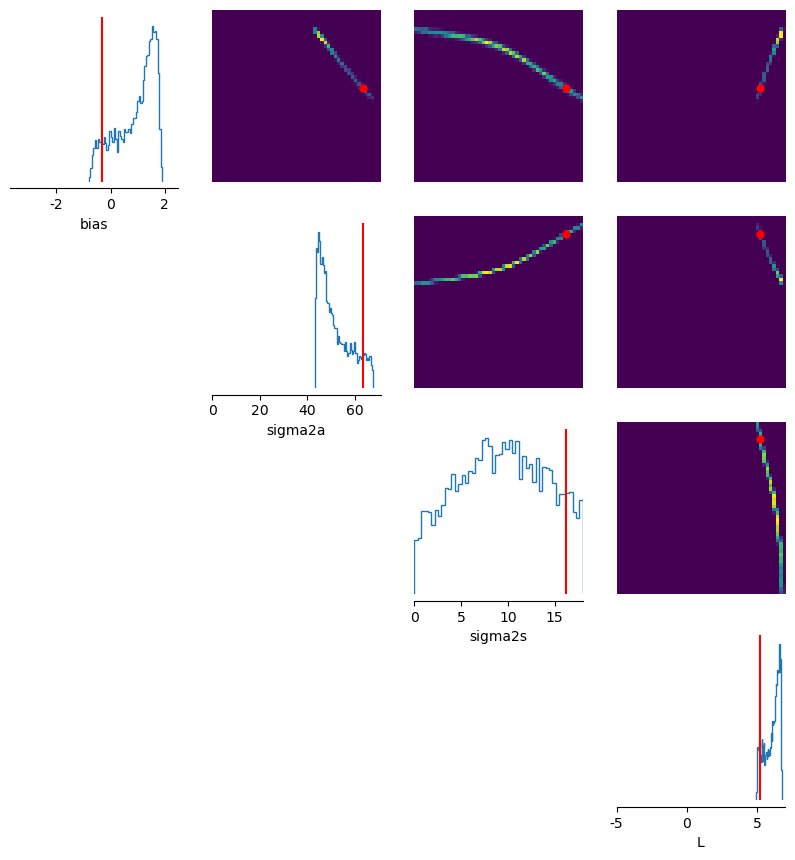

In [82]:
idx = 76
true_params = theta[idx, :]
print(f'input x: {x[idx, :]}')
print(f'true params: {true_params}')
samples = posterior.sample((5000,), x=x[idx, :])
fig, axes = analysis.pairplot(
    samples,
    limits=[[-3.7, 2.5], [0, 71], [0, 18], [-5, 7]],
    # ticks=[[], []],
    figsize=(10, 10),
    points=true_params,
    points_offdiag={'markersize': 10, 'markeredgewidth': 1},
    points_colors='r',
    labels = ['bias', 'sigma2a', 'sigma2s', 'L']
    )

## test with unseen x, theta pair

input_x: [0.5 0.5 0.5 0.6 0.6 0.6 0.4 0.4 0.5 0.4 0.5 0.6 0.5 0.5 0.4 1. ]


/Users/admin/anaconda3/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

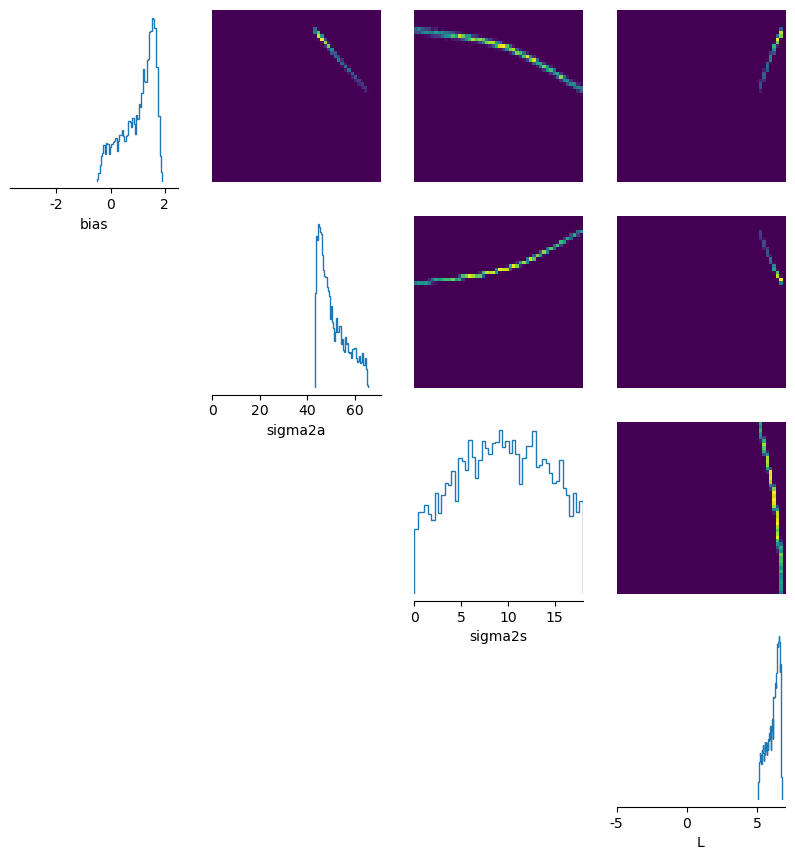

In [83]:
MS = 0.2
x_sample = np.random.choice([-1, 0, 1], size=(1, 14), p=[0.35, 0.3, 0.35])
x_sample = MS*np.insert(x_sample, 0, 0).reshape(1, -1)
# x_sample = x[10, :]
while x_sample in x:
    x_sample = np.random.choice([-1, 0, 1], size=(1, 14), p=[0.35, 0.3, 0.35])
    x_sample = MS*np.insert(x_sample, 0, 0).reshape(1, -1)

# normalize to [-1, 1]
x_sample = (x_sample + 1) / 2
x_sample = np.append(x_sample, 1).reshape(-1)
print(f'input_x: {x_sample}')

samples = posterior.sample((5000,), x=x_sample)
fig, axes = analysis.pairplot(
    samples,
    limits=[[-3.7, 2.5], [0, 71], [0, 18], [-5, 7]],
    # ticks=[[], []],
    figsize=(10, 10),
    # points=true_params,
    points_offdiag={'markersize': 10, 'markeredgewidth': 1},
    points_colors='r',
    labels = ['bias', 'sigma2a', 'sigma2s', 'L']
    )

## Inference pipeline - using pulses+L/R

In [51]:
from inference.inference import posterior_inference

experiement_id='a3'
subject_id=2
trial_len=15 
n_sub_samples=5000
trial_data_path='../data/trials.mat'
log_dir = Path(f'./src/train/logs/logs_L0_v1/log-train_L0-{experiement_id}')
ani_name = f'ani_{experiement_id}_subj_{subject_id}_trial_len_{trial_len}.mp4'
config_path = log_dir / 'config.yaml'

P = posterior_inference(config_path, 
                log_dir, 
                trial_data_path, 
                trial_len, 
                subject_id, 
                n_sub_samples,
                )

dict_keys(['clip_max_norm', 'discard_prior_samples', 'force_first_round_loss', 'learning_rate', 'max_num_epochs', 'method', 'num_atoms', 'prior_labels', 'prior_max_train', 'prior_min_train', 'resume_training', 'retrain_from_scratch', 'show_train_summary', 'stop_after_epochs', 'training_batch_size', 'use_combined_loss', 'validation_fraction'])
IndependentTransform(ComposeTransform(
    SigmoidTransform(),
    AffineTransform()
), 1)
tensor([[-0.5048, 15.5004,  0.4487,  0.8802],
        [ 2.2293, 23.9019,  7.4703,  0.6405]], device='cuda:0') tensor([[-0.4094,  0.0667, -3.6664,  2.7529],
        [ 2.8604,  1.3660, -0.3433,  1.5181]], device='cuda:0')
IndependentTransform(ComposeTransform(
    SigmoidTransform(),
    AffineTransform()
), 1)
tensor([[ 2.3612, 23.7291,  8.4427, -0.3400],
        [-0.8276, 11.3482, 13.7517,  0.2810]], device='cuda:0') tensor([[ 3.5561,  1.3308, -0.1240, -0.7082],
        [-0.6880, -0.4969,  1.1746,  0.5775]], device='cuda:0')
trial_data (2100, 15): [[ 0.   0.

100%|██████████| 2100/2100 [00:31<00:00, 66.30it/s]


posterior samples saved to src/train/logs/logs_L0_v1/log-train_L0-a3/samples.pkl


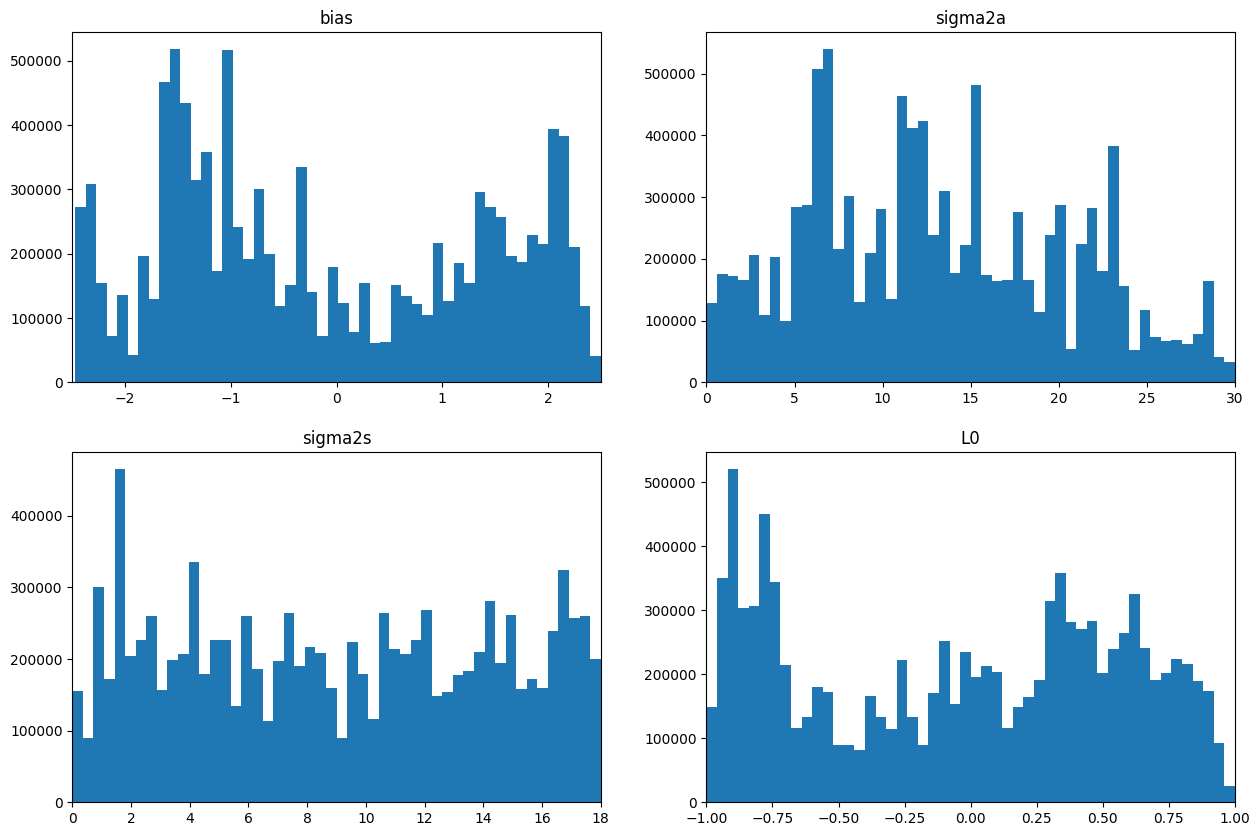

In [58]:
P.generate_one_hist(obs_data_idx=100)
P.gen_animation(ani_name)

## Inference pipeline - using summary(pulses)+probR

In [103]:
posterior._device

'cuda:0'

In [140]:
from inference.inference import load_posterior, posterior_sampling, load_trial_data, load_merged_config
from dataset.dataset_pipeline import process_x_seqC_part

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

experiement_id = 'c1'
subject_id=5
trial_len=15 
n_sub_samples=5000

trial_data_path='../data/trials.mat'
log_dir = Path(f'./src/train/logs/logs_L0_v1/log-train_L0-{experiement_id}')
ani_name = f'ani_{experiement_id}_subj_{subject_id}_trial_len_{trial_len}.mp4'
config_path = log_dir / 'config.yaml'

config = load_merged_config(config_path)

log_dir = Path(f'./src/train/logs/logs_L0_v1/log-train_L0-{experiement_id}')
density_estimator, posterior = load_posterior(log_dir)
next(density_estimator.parameters()).device

trial_data, trial_choice = load_trial_data(trial_data_path, trial_len, subject_id)
obs_data = process_x_seqC_part(trial_data, config)
obs_data = np.concatenate((obs_data, trial_choice), axis=1)
obs_data = torch.tensor(obs_data).float().to('cpu')
# posterior_sampling(obs_data, n_sub_samples, posterior)
samples = torch.zeros((obs_data.shape[0]*n_sub_samples, 4))
x = obs_data[0,:]
print(obs_data[0,:].device)

AttributeError: 'Flow' object has no attribute 'device'

In [132]:
samples_ = posterior.sample((n_sub_samples,), x=obs_data[0,:],show_progress_bars=False)

In [121]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
posterior.sample((20,), x=torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11, 1], device='cuda'), show_progress_bars=False)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!